# Mar ??, 2022 (remaining figs)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Fig dir

In [2]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(tmp_dir, 'fig_paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [3]:
mice = Mice(128)
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [4]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_bold).fit_group()

remove = [
    n for n, lbl in gr_ca.n2l.items()
    if lbl not in gr_bold.n2l.values()
]
include = np.delete(np.arange(len(gr_ca.n2l)), remove)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi[:, include],
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

ids

[0, 1, 2, 3, 4]

BOLD   : : :   ovp: 0.9943,  disj: 0.9816

Ca2    : : :   ovp: 0.9874,  disj: 0.9494

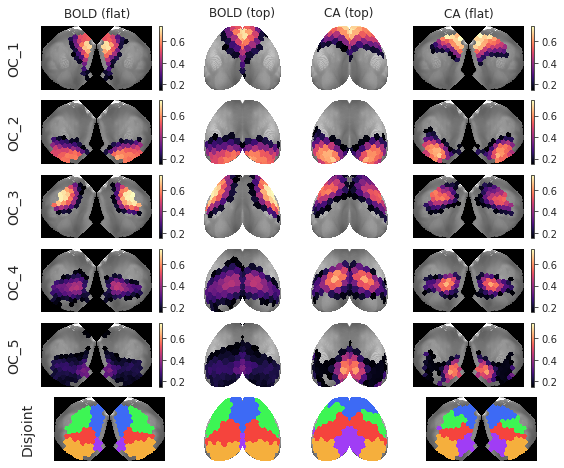

In [5]:
proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

ovp, disj = gr_bold.pi_symmetry_score(decimals=5)
print(f"BOLD   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
ovp, disj = gr_ca.pi_symmetry_score(decimals=5)
print(f"Ca2    : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

_ = gr_ca.show(
    proj_1=proj_bold,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    min_thres=0.15,
)

## New proportions fig

In [6]:
i, j, k = gr_bold.run_cut_prune.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}


b_grp_bold = bootstrap(
    x=gr_bold.run_cut_prune,
    n_resamples=int(1e5),
    batch=5,
    dims=dims,
    est=None,
)
b_grp_bold = bn.nanmean(bn.nanmean(bn.nanmean(b_grp_bold, 3), 2), 1)
se_boot = bn.nanstd(b_grp_bold, 0, ddof=1)
df_bold = gr_bold.mk_boot_df(se_boot, gr_bold.anim_cut_prune)


b_grp_ca = bootstrap(
    x=gr_ca.run_cut_prune,
    n_resamples=int(1e5),
    batch=5,
    dims=dims,
    est=None,
)
b_grp_ca = bn.nanmean(bn.nanmean(bn.nanmean(b_grp_ca, 3), 2), 1)
se_boot = bn.nanstd(b_grp_ca, 0, ddof=1)
df_ca = gr_ca.mk_boot_df(se_boot, gr_ca.anim_cut_prune)

In [7]:
mice.cfg.ll = 3

pi_srf = gr_ca.get_surface_pi(gr_ca.grp_pi)
proj = gr_ca.project_vec(pi_srf, layer=0, add_disjoint=False)
tr_ca = gr_ca.trim2d(proj)

pi_srf = gr_bold.get_surface_pi(gr_bold.grp_pi)
proj = gr_bold.project_vec(pi_srf, layer=0, add_disjoint=False)
tr_bold = gr_bold.trim2d(proj)

In [9]:
save_dir = pjoin(fig_dir, 'props')
os.makedirs(save_dir, exist_ok=True)

fig, axes, axes_inset = plot_proportions(df_ca, df_bold, figsize_x=15, figsize_y=6.1)
for oc, ax in enumerate(axes[0], start=1):
    ax.set_title(f'OC-{oc}', fontsize=20, y=1.03)
name = f'props'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)


fig, axes, axes_inset = plot_proportions(
    df_ca=df_ca,
    df_bold=df_bold,
    inset_ca=tr_ca,
    inset_bold=tr_bold,
    figsize_y=6.1,
    figsize_x=15,
)
for oc, ax in enumerate(axes[0], start=1):
    ax.set_title(f'OC-{oc}', fontsize=20, y=1.03)


name = f'props-inset'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)

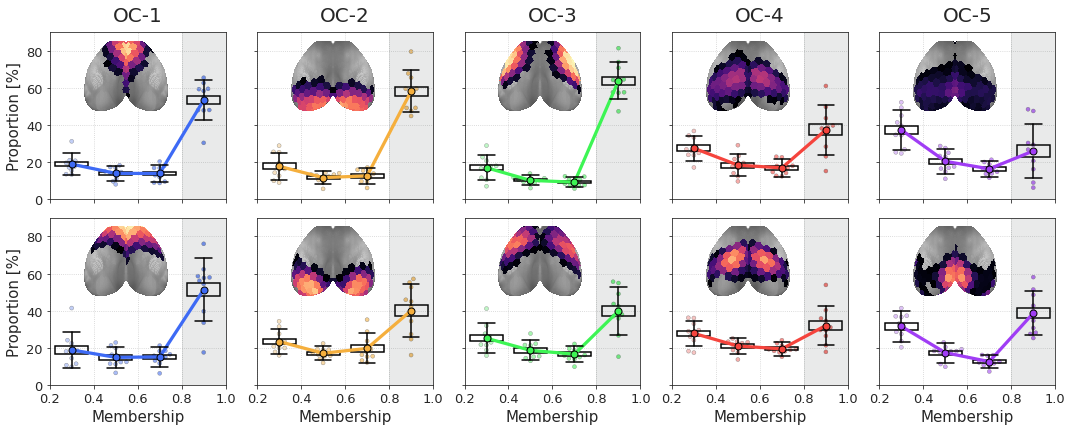

In [10]:
fig

In [11]:
fig, axes, axes_inset = plot_proportions(
    df_ca=df_ca,
    df_bold=df_bold,
    inset_ca=tr_ca,
    inset_bold=tr_bold,
    horizontal=False,
    figsize_x=13,
    figsize_y=6,
)
name = f'props-vert'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)

In [12]:
save_dir = pjoin(fig_dir, 'OCs')
os.makedirs(save_dir, exist_ok=True)

In [13]:
vmin, vmax = 0.15, 0.75
for i in range(5):

    fig, ax = create_figure(figsize=(1.5, 1))
    x2p = mwh(tr_bold['top'] == 0, tr_ca['top'])
    ax.imshow(x2p, cmap='Greys_r')
    x2p = mwh(tr_bold['proj-top'][i] < 0.15, tr_bold['proj-top'][i])
    ax.imshow(x2p, cmap='magma', vmin=vmin, vmax=vmax)
    remove_ticks(ax)

    name = f'OC-{i+1}_bold'
    for dpi in [1000]:
        figname = f"{name}_dpi{int(dpi / 100)}.png"
        fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
    plt.close()


    fig, ax = create_figure(figsize=(1.5, 1))
    x2p = mwh(tr_ca['top'] == 0, tr_ca['top'])
    ax.imshow(x2p, cmap='Greys_r')
    x2p = mwh(tr_ca['proj-top'][i] < 0.15, tr_ca['proj-top'][i])
    ax.imshow(x2p, cmap='magma', vmin=vmin, vmax=vmax)
    remove_ticks(ax)

    name = f'OC-{i+1}_ca'
    for dpi in [1000]:
        figname = f"{name}_dpi{int(dpi / 100)}.png"
        fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
    plt.close()

## Pacman figure

In [14]:
thres = 0.15

In [15]:
x = gr_ca.run_pi_prune > thres
ovp_nodes = x.sum(-2, keepdims=True) > 1
portion_ovp_ca = (ovp_nodes * x).sum(-1) / x.sum(-1) * 100
portion_ovp_ca_avg = bn.nanmean(bn.nanmean(bn.nanmean(portion_ovp_ca, 2), 1), 0)

x = gr_bold.run_pi_prune > thres
ovp_nodes = x.sum(-2, keepdims=True) > 1
portion_ovp_bold = (ovp_nodes * x).sum(-1) / x.sum(-1) * 100
portion_ovp_bold_avg = bn.nanmean(bn.nanmean(bn.nanmean(portion_ovp_bold, 2), 1), 0)

In [16]:
portion_ovp_ca_avg, portion_ovp_bold_avg

(
    array([53.14181806, 61.40457417, 64.98576452, 72.8104184 , 66.4515027 ]),
    array([51.19666351, 47.44557608, 41.87374306, 66.98452427, 77.03523231])
)

In [17]:
i, j, k = portion_ovp_bold.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

boot = bootstrap(
    x=portion_ovp_bold,
    n_resamples=int(1e5),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(bn.nanmean(boot, 3), 2), 1)
se_bold = bn.nanstd(boot, 0, ddof=1)

boot = bootstrap(
    x=portion_ovp_ca,
    n_resamples=int(1e5),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(bn.nanmean(boot, 3), 2), 1)
se_ca = bn.nanstd(boot, 0, ddof=1)

se_bold, se_ca

(
    array([3.01734519, 3.7109728 , 3.23864171, 3.96605535, 4.08379403]),
    array([4.64774866, 3.66677369, 3.63028779, 2.98317964, 3.16497856])
)

In [18]:
ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
t = sp_stats.t.ppf(whis, dof)

e_bold, e_ca = se_bold * t, se_ca * t
e_bold, e_ca

(
    array([6.82570903, 8.39480371, 7.32631655, 8.97184052, 9.23818391]),
    array([10.51393792,  8.29481836,  8.21228152,  6.74842118,  7.15967892])
)

In [19]:
save_dir = pjoin(fig_dir, 'pie-OCs')
os.makedirs(save_dir, exist_ok=True)

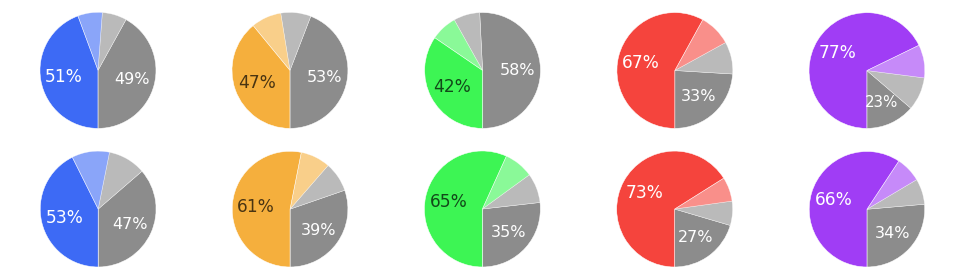

In [20]:
grey = list(sns.color_palette('deep'))[-3]
fig, axes = create_figure(2, 5, (13.5, 4))

for k in range(5):
    ax = axes[0, k]
    x = [100 - portion_ovp_bold_avg[k] - e_bold[k], e_bold[k], e_bold[k], portion_ovp_bold_avg[k] - e_bold[k]]
    patches, _, autotexts = ax.pie(
        x=x,
        # labels=['Disjoint', 'Mixed'],
        explode=(0,) * len(x),
        autopct='%1.0f%%',
        shadow=False,
        startangle=270,
        labeldistance=1.2,
        colors=[grey] * 2 + [gr_bold.colors[k + 1]] * 2,
        wedgeprops = {'linewidth': 0.5},
        textprops={'fontsize': 16},
    )
    for i, t in enumerate(autotexts):
        t.set_color('white')
        if i == 0:
            t.set_text(f"{sum(x[:2]):0.0f}%")
            if k == 4:
                t.set_fontsize(15)
        elif i in [1, 2]:
            t.set_text('')
            patches[i].set_alpha(0.6)
        else:
            t.set_text(f"{sum(x[2:]):0.0f}%")
            t.set_fontsize(17)
            if k in [1, 2]:
                t.set_color('k')
                t.set_alpha(0.7)
    ax.axis('equal')
    
    ax = axes[1, k]
    x = [100 - portion_ovp_ca_avg[k] - e_ca[k], e_ca[k], e_ca[k], portion_ovp_ca_avg[k] - e_ca[k]]
    patches, _, autotexts = ax.pie(
        x=x,
        # labels=['Disjoint', 'Mixed'],
        explode=(0,) * len(x),
        autopct='%1.0f%%',
        shadow=False,
        startangle=270,
        labeldistance=1.2,
        colors=[grey] * 2 + [gr_ca.colors[k + 1]] * 2,
        wedgeprops = {'linewidth': 0.5},
        textprops={'fontsize': 16},
    )
    for i, t in enumerate(autotexts):
        t.set_color('white')
        if i == 0:
            t.set_text(f"{sum(x[:2]):0.0f}%")
        elif i in [1, 2]:
            t.set_text('')
            patches[i].set_alpha(0.6)
        else:
            t.set_text(f"{sum(x[2:]):0.0f}%")
            t.set_fontsize(17)
            if k in [1, 2]:
                t.set_color('k')
                t.set_alpha(0.7)
    ax.axis('equal')
name = f'OCS_thres{thres:.2f}'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
plt.show()

## Entropy with log(k) / log(5)

In [21]:
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter
from matplotlib.pyplot import text as mp_txt
set_style()

In [22]:
num = 100
bins = np.linspace(-1 / num, 1.0, num + 2)
xs = (bins[1:] + bins[:-1]) / 2
xs[0] = 0

In [23]:
i, j, k = gr_bold.run_h.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}


h_bold = cut_data(
    data=gr_bold.run_h.reshape(-1, 1, 174),
    bins=bins,
    oc_only=True,
)[0].reshape(i, j, k, -1)
h_bold_avg = bn.nanmean(bn.nanmean(bn.nanmean(h_bold, 2), 1), 0)

boot = bootstrap(
    x=h_bold,
    n_resamples=int(1e4),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(bn.nanmean(boot, 3), 2), 1)
se_bold = bn.nanstd(boot, 0, ddof=1)


h_ca = cut_data(
    data=gr_ca.run_h.reshape(-1, 1, 174),
    bins=bins,
    oc_only=True,
)[0].reshape(i, j, k, -1)
h_ca_avg = bn.nanmean(bn.nanmean(bn.nanmean(h_ca, 2), 1), 0)

boot = bootstrap(
    x=h_ca,
    n_resamples=int(1e4),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(bn.nanmean(boot, 3), 2), 1)
se_ca = bn.nanstd(boot, 0, ddof=1)

In [24]:
ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
t = sp_stats.t.ppf(whis, dof)

In [25]:
h_bold = sp_stats.entropy(gr_bold.grp_pi_prune) / np.log(gr_bold.num_k)
h_ca = sp_stats.entropy(gr_ca.grp_pi_prune) / np.log(gr_ca.num_k)

hr_bold = sp_stats.rankdata(h_bold)
hr_ca = sp_stats.rankdata(h_ca)


h_thres = -np.inf
hpb = gr_bold.project_vec(h_bold, thres=h_thres, add_disjoint=False)
hpc = gr_ca.project_vec(h_ca, thres=h_thres, add_disjoint=False)

hrpb = gr_bold.project_vec(hr_bold, thres=h_thres, add_disjoint=False)
hrpc = gr_ca.project_vec(hr_ca, thres=h_thres, add_disjoint=False)


trb = gr_bold.trim2d(hrpb)
trc = gr_bold.trim2d(hrpc)

In [26]:
def _add_line(ax, text=False):
    for i in range(1, 5):
        x = np.log(i) / np.log(5)
        ax.axvline(x, color='dimgrey', ls='--', lw=1.2)
        if text:
            mp_txt(
                x=x + 0.005,
                y=100 if i == 1 else 56,
                s=f"$\log({i}) \,\,/\,\, \log(5)$",
                fontsize=14,
                rotation=270,
                va='top',
            )
        x = (0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)
        ax.axvline(x, color='magenta', ls='-.', lw=1.5)

Text(0.5, 1.0, 'Ca$^{2+}$')

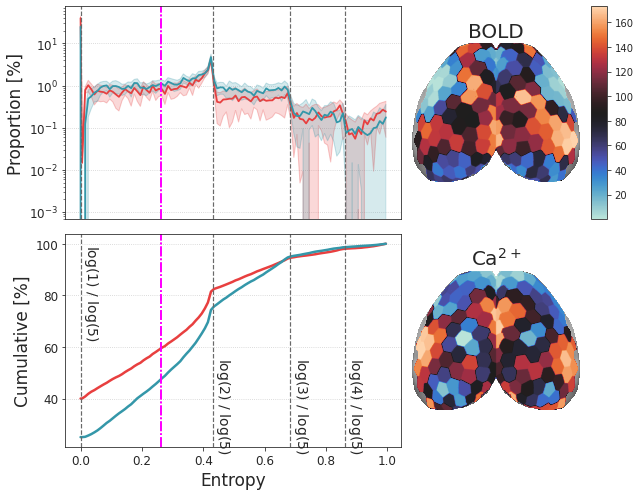

In [27]:
set_style()
fig = plt.figure(figsize=(9, 7), tight_layout=True)
gs = gridspec.GridSpec(2, 3, width_ratios=[2, 1, 0.1])

ax = fig.add_subplot(gs[0, 0])
for y, color in zip([h_bold_avg, h_ca_avg], [pal['bold-lite'], pal['ca2']]):
    lo = y - se_ca * t
    hi = y + se_ca * t
    ax.plot(xs, y, color=color, lw=1.8)
    ax.plot(xs, lo, color=color, lw=1., alpha=0.1)
    ax.plot(xs, hi, color=color, lw=1., alpha=0.1)
    ax.fill_between(xs, lo, hi, color=color, alpha=0.2)
ax.set_ylabel('Proportion [%]', fontsize=17)
ax.set_yscale('log')
ax.grid(axis='y')
_add_line(ax)
ax.set_xticks([])
ax.tick_params(axis='y', labelsize=12)

ax = fig.add_subplot(gs[1, 0])
ax.plot(xs, np.cumsum(h_bold_avg), lw=2.5, color=pal['bold-lite'])
ax.plot(xs, np.cumsum(h_ca_avg), lw=2.5, color=pal['ca2'])
ax.set_ylabel('Cumulative [%]', fontsize=17)
ax.grid(axis='y')
_add_line(ax, True)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel('Entropy', fontsize=17)


cax = fig.add_subplot(gs[0, 2])
ax = fig.add_subplot(gs[0, 1])

x2p = np.ma.masked_where(trb['top'] == 0, trb['top'])
ax.imshow(x2p, cmap='Greys_r')

x2p = gaussian_filter(trb['proj-top'][0], sigma=1)
x2p = np.ma.masked_where(x2p == 0, x2p)
im = ax.imshow(x2p, cmap='icefire', interpolation='antialiased')
plt.colorbar(im, cax=cax, aspect=10)#, shrink=0.3)
remove_ticks(ax)
ax.set_title('BOLD', fontsize=20)

ax = fig.add_subplot(gs[1, 1])

x2p = np.ma.masked_where(trc['top'] == 0, trc['top'])
ax.imshow(x2p, cmap='Greys_r')

x2p = gaussian_filter(trc['proj-top'][0], sigma=1)
x2p = np.ma.masked_where(x2p == 0, x2p)
ax.imshow(x2p, cmap='icefire', interpolation='antialiased')
remove_ticks(ax)
ax.set_title(r'Ca$^{2+}$', fontsize=20)

In [391]:
save_dir = pjoin(fig_dir, 'entropy')
os.makedirs(save_dir, exist_ok=True)

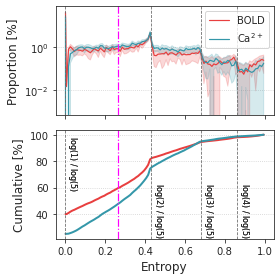

In [29]:
fig, axes = create_figure(2, 1, figsize=(4, 4), sharex='col')

data2p = {'BOLD': h_bold_avg, r'Ca$^{2+}$': h_ca_avg}
ax = axes[0]
for (lbl, y), color in zip(data2p.items(), [pal['bold-lite'], pal['ca2']]):
    lo = y - se_ca * t
    hi = y + se_ca * t
    ax.plot(xs, y, color=color, lw=1.2, label=lbl)
    ax.plot(xs, lo, color=color, lw=0.1, alpha=0.1)
    ax.plot(xs, hi, color=color, lw=0.1, alpha=0.1)
    ax.fill_between(xs, lo, hi, color=color, alpha=0.2)
ax.set_ylabel('Proportion [%]', fontsize=12)
ax.set_yscale('log')
ax.grid(axis='y')
ax.legend()

ax = axes[1]
ax.plot(xs, np.cumsum(h_bold_avg), lw=2, color=pal['bold-lite'])
ax.plot(xs, np.cumsum(h_ca_avg), lw=2, color=pal['ca2'])
ax.set_ylabel('Cumulative [%]', fontsize=12)

for ax in axes.flat:
    for i in range(1, 5):
        x = np.log(i) / np.log(5)
        ax.axvline(x, color='dimgrey', ls='--', lw=0.8)
        mp_txt(
            x=x + 0.005,
            y=100 if i == 1 else 64,
            s=f"$\log({i}) \,\,/\,\, \log(5)$",
            fontsize=8,
            rotation=270,
            va='top',
        )

    x = (0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)
    ax.axvline(x, color='magenta', ls='-.', lw=1.2)
ax.grid(axis='y')
ax.set_xlabel('Entropy', fontsize=12)

name = 'ent-hist'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)

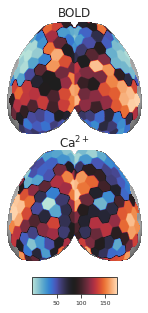

In [183]:
fig = plt.figure(figsize=(4, 5), constrained_layout=True)
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1.5, 1.0], height_ratios=[1, 1, 0.15])

ax = fig.add_subplot(gs[0, :])
x2p = np.ma.masked_where(trb['top'] == 0, trb['top'])
ax.imshow(x2p, cmap='Greys_r')

x2p = gaussian_filter(trb['proj-top'][0], sigma=1)
x2p = np.ma.masked_where(x2p == 0, x2p)
ax.imshow(x2p, cmap='icefire', interpolation='antialiased')
ax.set_title('BOLD', fontsize=12, y=0.99)
remove_ticks(ax)

ax = fig.add_subplot(gs[1, :])
x2p = np.ma.masked_where(trc['top'] == 0, trc['top'])
ax.imshow(x2p, cmap='Greys_r')

x2p = gaussian_filter(trc['proj-top'][0], sigma=1)
x2p = np.ma.masked_where(x2p == 0, x2p)
im = ax.imshow(x2p, cmap='icefire', interpolation='antialiased')
ax.set_title(r'Ca$^{2+}$', fontsize=12, y=0.96)
remove_ticks(ax)

cax = fig.add_subplot(gs[2, 1])
plt.colorbar(im, cax=cax, orientation='horizontal')
cax.tick_params(labelsize=6) 

name = 'ent-ctx-4by5'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)

### What about anim h?

In [161]:
num = 20
bins = np.linspace(-1 / num, 1.0, num + 2)
xs = (bins[1:] + bins[:-1]) / 2
xs[0] = 0

<AxesSubplot:ylabel='Count'>

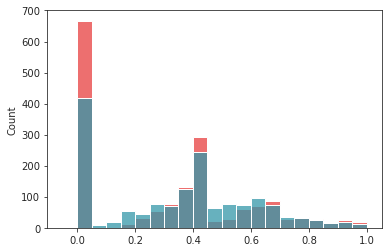

In [162]:
sns.histplot(gr_bold.anim_h.ravel(), bins=bins, color=pal['bold-lite'])
sns.histplot(gr_ca.anim_h.ravel(), bins=bins, color=pal['ca2'])

In [170]:
i, j, k = gr_bold.run_h.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

h_bold = cut_data(
    data=np.expand_dims(gr_bold.anim_h, 1),
    bins=bins,
    oc_only=True,
)[0].squeeze()
h_bold_avg = bn.nanmean(h_bold, 0)

boot = bootstrap(
    x=gr_bold.run_pi_prune,
    n_resamples=int(1e3),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(boot, 3), 2)
boot = sp_stats.entropy(boot, axis=-2) / np.log(5)
boot = cut_data(
    data=boot,
    bins=bins,
    oc_only=True,
)[0].squeeze()
boot = bn.nanmean(boot, 1)
se_bold = bn.nanstd(boot, 0, ddof=1)


h_ca = cut_data(
    data=np.expand_dims(gr_ca.anim_h, 1),
    bins=bins,
    oc_only=True,
)[0].squeeze()
h_ca_avg = bn.nanmean(h_ca, 0)

boot = bootstrap(
    x=gr_ca.run_pi_prune,
    n_resamples=int(1e3),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(boot, 3), 2)
boot = sp_stats.entropy(boot, axis=-2) / np.log(5)
boot = cut_data(
    data=boot,
    bins=bins,
    oc_only=True,
)[0].squeeze()
boot = bn.nanmean(boot, 1)
se_ca = bn.nanstd(boot, 0, ddof=1)

In [171]:
ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
t = sp_stats.t.ppf(whis, dof)

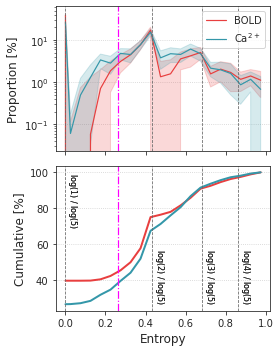

In [180]:
fig, axes = create_figure(2, 1, figsize=(4, 5), sharex='col')

data2p = {'BOLD': h_bold_avg, r'Ca$^{2+}$': h_ca_avg}
ax = axes[0]
for (lbl, y), color in zip(data2p.items(), [pal['bold-lite'], pal['ca2']]):
    lo = y - se_ca * t
    hi = y + se_ca * t
    ax.plot(xs, y, color=color, lw=1.2, label=lbl)
    ax.plot(xs, lo, color=color, lw=0.1, alpha=0.1)
    ax.plot(xs, hi, color=color, lw=0.1, alpha=0.1)
    ax.fill_between(xs, lo, hi, color=color, alpha=0.2)
ax.set_ylabel('Proportion [%]', fontsize=12)
ax.set_yscale('log')
ax.grid(axis='y')
ax.legend()

ax = axes[1]
ax.plot(xs, np.cumsum(h_bold_avg), lw=2, color=pal['bold-lite'])
ax.plot(xs, np.cumsum(h_ca_avg), lw=2, color=pal['ca2'])
ax.set_ylabel('Cumulative [%]', fontsize=12)

for ax in axes.flat:
    for i in range(1, 5):
        x = np.log(i) / np.log(5)
        ax.axvline(x, color='dimgrey', ls='--', lw=0.8)
        mp_txt(
            x=x + 0.005,
            y=100 if i == 1 else 58,
            s=f"$\log({i}) \,\,/\,\, \log(5)$",
            fontsize=8,
            rotation=270,
            va='top',
        )

    x = (0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)
    ax.axvline(x, color='magenta', ls='-.', lw=1.2)
ax.grid(axis='y')
ax.set_xlabel('Entropy', fontsize=12)

name = 'ent-hist-anim'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)

## Carto

In [184]:
len(gr_bold.run_h.flat), len(gr_bold.run_deg.flat)

(20880, 20880)

In [185]:
num = len(gr_ca.run_h.flat)

In [186]:
df = pd.DataFrame({
    'mode': ['ca2'] * num + ['bold-lite'] * num,
    'Degree': list(gr_ca.run_deg.flat) + list(gr_bold.run_deg.flat),
    'Entropy': list(gr_ca.run_h.flat) + list(gr_bold.run_h.flat),
})

In [34]:
df

,mode,Degree,Entropy
0,ca2,NaN,NaN
1,ca2,NaN,NaN
2,ca2,NaN,NaN
3,ca2,NaN,NaN
4,ca2,NaN,NaN
...,...,...,...
41755,bold-lite,8.0,0.000000
41756,bold-lite,25.0,0.000000
41757,bold-lite,5.0,0.000000
41758,bold-lite,4.0,0.242585


In [35]:
41760 / num

2.0

<AxesSubplot:xlabel='Entropy', ylabel='Degree'>

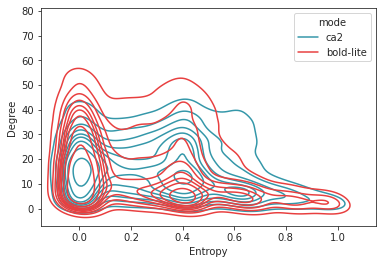

In [36]:
sns.kdeplot(
    data=df,
    x='Entropy',
    y='Degree',
    hue='mode',
    palette=pal,
)

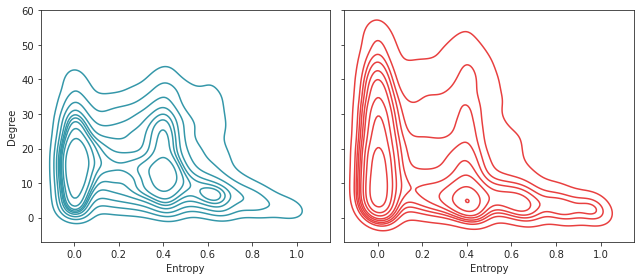

In [37]:
ylim_max = 60

fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()): 
    sns.kdeplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        color=c,
        ax=ax,
    )
ylim = ax.get_ylim()
ax.set_ylim((ylim[0], ylim_max))
plt.show()

### Full df

In [6]:
affil, affil_included = gr_ca.node_affiliations()

In [7]:
dlist = []
looper = itertools.product(range(10), range(3), range(4))
for i, j, k in looper:
    if np.isnan(gr_ca.run_h[i, j, k]).sum() < len(gr_ca.n2l):
        dlist.append({
            'mode': ['ca2'] * len(affil_included),
            'subject': [i + 1] * len(affil_included),
            'session': [j + 1] * len(affil_included),
            'run': [k + 1] * len(affil_included),
            'Affiliation': affil_included,
            'Entropy': gr_ca.run_h[i, j, k],
            'Degree': gr_ca.run_deg[i, j, k],
        })
    if np.isnan(gr_bold.run_h[i, j, k]).sum() < len(gr_bold.n2l):
        dlist.append({
            'mode': ['bold-lite'] * len(affil_included),
            'subject': [i + 1] * len(affil_included),
            'session': [j + 1] * len(affil_included),
            'run': [k + 1] * len(affil_included),
            'Affiliation': affil_included,
            'Entropy': gr_bold.run_h[i, j, k],
            'Degree': gr_bold.run_deg[i, j, k],
        })
df = pd.DataFrame(merge_dicts(dlist))
df.shape

(40368, 7)

In [189]:
sp_stats.entropy([0.15, 0.85, 0, 0, 0]) / np.log(5), sp_stats.entropy([0.2, 0.8, 0, 0, 0]) / np.log(5)

(0.26264392340968856, 0.31091750708257115)

In [190]:
# x = (0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)
vlines = [np.log(i) / np.log(5) for i in range(2, 5)]
hlines = [15]

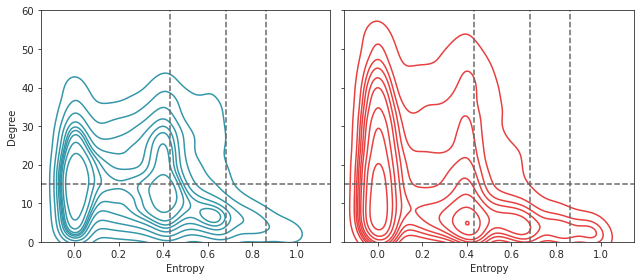

In [191]:
fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()):
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--')
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--')
    sns.kdeplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        color=c,
        ax=ax,
    )
ax.set_ylim((0, 60))

plt.show()

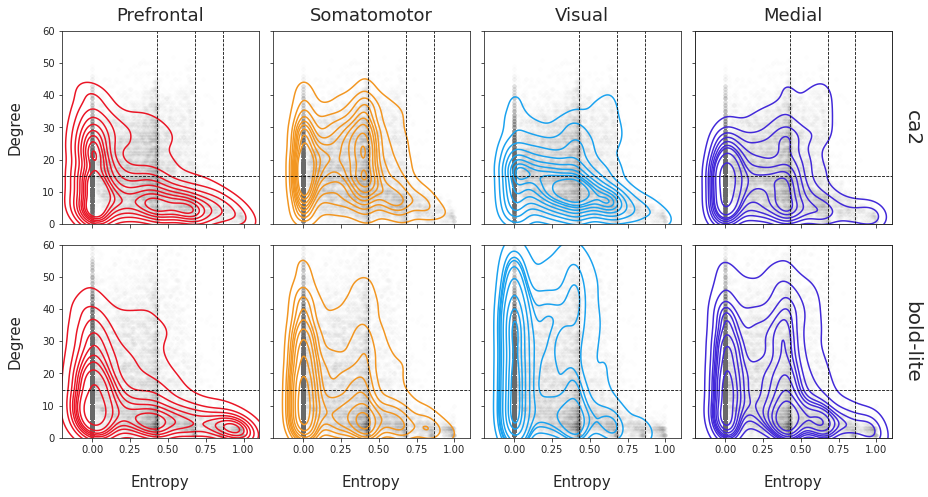

In [192]:
selected = ['Prefrontal', 'Somatomotor', 'Visual', 'Medial']

fig, axes = create_figure(2, len(selected), (13, 7), 'all', 'all')

for ax in axes.flat:
    for x in vlines:
        ax.axvline(x, color='k', ls='--', lw=0.8)
    for y in hlines:
        ax.axhline(y, color='k', ls='--', lw=0.8)

for i, af in enumerate(selected):
    for ax, (mode, c) in zip(axes[:, i].flat, pal.items()):
        _df = df.loc[
            (df['mode'] == mode) &
            (df['Affiliation'] == af)
        ]
        sns.scatterplot(
            data=df.loc[df['mode'] == mode],
            x='Entropy',
            y='Degree',
            color='dimgrey',
            s=20,
            alpha=0.01,
            ax=ax,
        )
        sns.kdeplot(
            data=_df,
            x='Entropy',
            y='Degree',
            color=affil['colors'][af],
            ax=ax,
        )
        if mode == 'ca2':
            ax.set_title(af, fontsize=18, y=1.02)
        else:
            ax.set_xlabel('Entropy', fontsize=15, labelpad=20)
        if i == len(selected) - 1:
            axtw = ax.twinx()
            axtw.set_ylabel(mode, fontsize=20, labelpad=30, rotation=-90)
            axtw.set_yticks([])
        elif i == 0:
            ax.set_ylabel('Degree', fontsize=15, labelpad=20)
ax.set_ylim((0, 60))
ax.set_xlim((-0.2, 1.1))

plt.show()

In [46]:
vedges = [0] + vlines + [1]
hedges = [0] + hlines + [100]

coordinates = {}
for i in range(len(hedges) - 1):
    for j in range(len(vedges) - 1):
        coordinates[f"{i}{j}"] = (
            (hedges[i], hedges[i + 1]),
            (vedges[j], vedges[j + 1]),
        )
coordinates

{
    '00': ((0, 15), (0, 0.43067655807339306)),
    '01': ((0, 15), (0.43067655807339306, 0.6826061944859854)),
    '02': ((0, 15), (0.6826061944859854, 0.8613531161467861)),
    '03': ((0, 15), (0.8613531161467861, 1)),
    '10': ((15, 100), (0, 0.43067655807339306)),
    '11': ((15, 100), (0.43067655807339306, 0.6826061944859854)),
    '12': ((15, 100), (0.6826061944859854, 0.8613531161467861)),
    '13': ((15, 100), (0.8613531161467861, 1))
}

In [47]:
carto_map = {}
for k, bounds in coordinates.items():
    (lower_deg, upper_deg), (lower_h, upper_h) = bounds
    cond_h = np.logical_and(lower_h <= gr_ca.run_h, gr_ca.run_h < upper_h)
    cond_deg = np.logical_and(lower_deg <= gr_ca.run_deg, gr_ca.run_deg < upper_deg)
    cond = np.logical_and(cond_h, cond_deg)
    carto_map[k] = bn.nanmean(bn.nanmean(bn.nanmean(cond, 2), 1), 0)
    
carto_vec = [np.expand_dims(e, axis=0) for e in carto_map.values()]
carto_vec = np.concatenate(carto_vec)
proj = gr_ca.project_vec(carto_vec, add_disjoint=False)
tr = gr_ca.trim2d(proj)

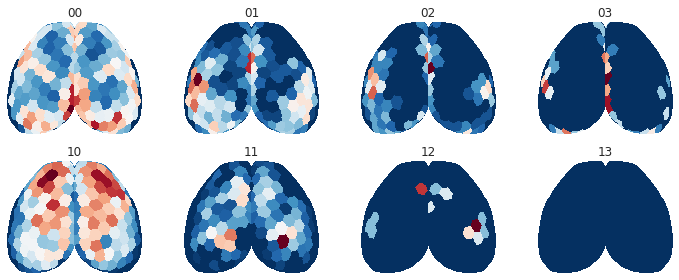

In [50]:
fig, axes = create_figure(2, 4, (10, 4))
for i, k in enumerate(coordinates):
    ax = axes.flat[i]
    x2p = mwh(tr['top'] == 0, tr['proj-top'][i])
    ax.imshow(x2p, cmap='RdBu_r')
    ax.set_title(k)
remove_ticks(axes)

In [51]:
carto_map = {}
for k, bounds in coordinates.items():
    (lower_deg, upper_deg), (lower_h, upper_h) = bounds
    cond_h = np.logical_and(lower_h <= gr_bold.run_h, gr_bold.run_h < upper_h)
    cond_deg = np.logical_and(lower_deg <= gr_bold.run_deg, gr_bold.run_deg < upper_deg)
    cond = np.logical_and(cond_h, cond_deg)
    carto_map[k] = bn.nanmean(bn.nanmean(bn.nanmean(cond, 2), 1), 0)
    
carto_vec = [np.expand_dims(e, axis=0) for e in carto_map.values()]
carto_vec = np.concatenate(carto_vec)
proj = gr_bold.project_vec(carto_vec, add_disjoint=False)
tr = gr_bold.trim2d(proj)

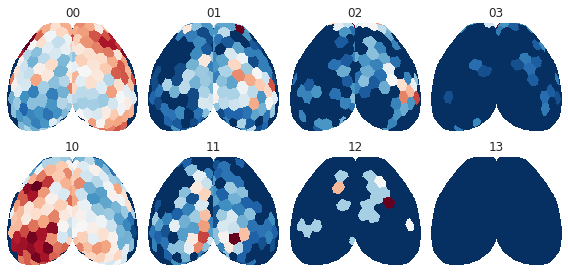

In [53]:
fig, axes = create_figure(2, 4, (8, 4))
for i, k in enumerate(coordinates):
    ax = axes.flat[i]
    x2p = mwh(tr['top'] == 0, tr['proj-top'][i])
    ax.imshow(x2p, cmap='RdBu_r')
    ax.set_title(k)
remove_ticks(axes)

### Animal

In [6]:
gr_ca.anim_deg = bn.nanmean(bn.nanmean(gr_ca.run_deg, 2), 1)
gr_bold.anim_deg = bn.nanmean(bn.nanmean(gr_bold.run_deg, 2), 1)

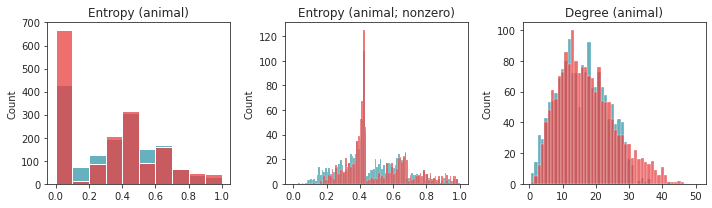

In [7]:
fig, axes = create_figure(1, 3, (10, 3), 'col')
sns.histplot(gr_ca.anim_h[np.isfinite(gr_ca.anim_h)],
             bins=np.linspace(0, 1.0, 11), color=pal['ca2'], ax=axes[0])
sns.histplot(gr_bold.anim_h[np.isfinite(gr_bold.anim_h)],
             bins=np.linspace(0, 1.0, 11), color=pal['bold-lite'], ax=axes[0])
axes[0].set_title('Entropy (animal)')

sns.histplot(gr_ca.anim_h[gr_ca.anim_h.nonzero()],
             bins=np.linspace(0, 1.0, 101), color=pal['ca2'], ax=axes[1])
sns.histplot(gr_bold.anim_h[gr_bold.anim_h.nonzero()],
             bins=np.linspace(0, 1.0, 101), color=pal['bold-lite'], ax=axes[1])
axes[1].set_title('Entropy (animal; nonzero)')

sns.histplot(gr_ca.anim_deg[np.isfinite(gr_ca.anim_deg)],
             bins=np.linspace(0.5, 50.5, 51), color=pal['ca2'], ax=axes[2])
sns.histplot(gr_bold.anim_deg[np.isfinite(gr_bold.anim_deg)],
             bins=np.linspace(0.5, 50.5, 51), color=pal['bold-lite'], ax=axes[2])
axes[2].set_title('Degree (animal)')

plt.show()

In [195]:
x = gr_bold.anim_h[gr_bold.anim_h.nonzero()]
x = x[~np.isnan(x)]
len(x)

1021

In [196]:
bins = np.linspace(0, 1.0, 1001)
bins

array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ])

In [197]:
hist, bin_edges = np.histogram(x, bins=bins)

In [198]:
max_count = np.max(hist)
max_id = np.where(hist == max_count)[0].item()

max_count, max_id

(45, 430)

In [199]:
bins[max_id], bins[max_id + 1]

(0.43, 0.431)

In [200]:
np.log(2) / np.log(5)

0.43067655807339306

In [201]:
cond = np.logical_and(0.430 < gr_bold.anim_h, gr_bold.anim_h < 0.431)
ids = list(zip(*np.where(cond)))

In [202]:
for i, j in ids:
    print(i, j, np.round(gr_bold.anim_pi_prune[i, :, j], 2))

0 2 [0.52 0.   0.48 0.   0.  ]

0 40 [0.5 0.  0.  0.5 0. ]

0 44 [0.  0.  0.5 0.  0.5]

0 45 [0.   0.   0.48 0.   0.52]

0 51 [0.   0.   0.   0.48 0.52]

0 60 [0.   0.48 0.   0.   0.52]

1 65 [0.  0.5 0.  0.5 0. ]

1 77 [0.   0.52 0.   0.   0.48]

1 96 [0.48 0.   0.52 0.   0.  ]

1 109 [0.51 0.   0.49 0.   0.  ]

2 14 [0.49 0.   0.51 0.   0.  ]

2 144 [0.   0.   0.   0.49 0.51]

2 146 [0.   0.   0.   0.49 0.51]

2 159 [0.   0.48 0.   0.   0.52]

3 27 [0.51 0.   0.49 0.   0.  ]

3 60 [0.  0.5 0.  0.  0.5]

3 98 [0.5 0.  0.5 0.  0. ]

3 121 [0.49 0.   0.   0.51 0.  ]

3 159 [0.   0.52 0.   0.   0.48]

4 20 [0.49 0.   0.51 0.   0.  ]

4 45 [0.   0.   0.49 0.   0.51]

4 54 [0.  0.5 0.  0.  0.5]

4 59 [0.   0.52 0.   0.   0.48]

4 60 [0.   0.48 0.   0.   0.52]

4 76 [0.  0.5 0.  0.  0.5]

4 143 [0.  0.  0.  0.5 0.5]

4 144 [0.  0.5 0.  0.5 0. ]

5 22 [0.   0.   0.52 0.   0.48]

6 132 [0.  0.  0.  0.5 0.5]

6 134 [0.  0.  0.  0.5 0.5]

6 142 [0.48 0.   0.   0.   0.52]

6 146 [0.  0.5 0.  0.  0.5]

6 147 [0.   0.51 0.   0.   0.49]

6 149 [0.   0.49 0.   0.   0.51]

7 57 [0.   0.48 0.   0.52 0.  ]

7 64 [0.   0.49 0.   0.51 0.  ]

7 96 [0.5 0.  0.5 0.  0. ]

7 136 [0.   0.   0.   0.52 0.48]

7 139 [0.   0.52 0.   0.48 0.  ]

8 47 [0.  0.  0.  0.5 0.5]

8 71 [0.   0.49 0.   0.   0.51]

8 145 [0.   0.51 0.   0.49 0.  ]

8 158 [0.   0.48 0.   0.   0.52]

9 44 [0.   0.   0.49 0.51 0.  ]

9 109 [0.52 0.   0.48 0.   0.  ]

In [13]:
affil, affil_included = gr_ca.node_affiliations()

In [15]:
dlist = []
for i in range(10):
    dlist.append({
        'mode': ['ca2'] * len(affil_included),
        'subject': [i + 1] * len(affil_included),
        'Affiliation': affil_included,
        'Entropy': gr_ca.anim_h[i],
        'Degree': gr_ca.anim_deg[i],
    })
    dlist.append({
        'mode': ['bold-lite'] * len(affil_included),
        'subject': [i + 1] * len(affil_included),
        'Affiliation': affil_included,
        'Entropy': gr_bold.anim_h[i],
        'Degree': gr_bold.anim_deg[i],
    })
df = pd.DataFrame(merge_dicts(dlist))

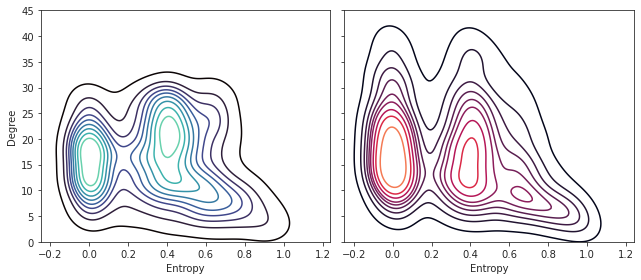

In [205]:
fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()): 
    sns.kdeplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        cmap='mako' if mode == 'ca2' else 'rocket',
        #color=c,
        ax=ax,
    )
ax.set_ylim((0, 45))
plt.show()

In [208]:
vlines = [(0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)]
vlines += [np.log(i) / np.log(5) for i in range(2, 5)]
hlines = [15]

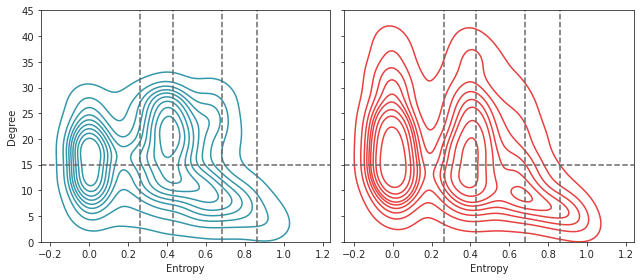

In [209]:
fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()):
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--')
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--')
    sns.kdeplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        color=c,
        ax=ax,
    )
ax.set_ylim((0, 45))

plt.show()

In [210]:
selected = ['Prefrontal', 'Somatomotor', 'Visual', 'Medial']

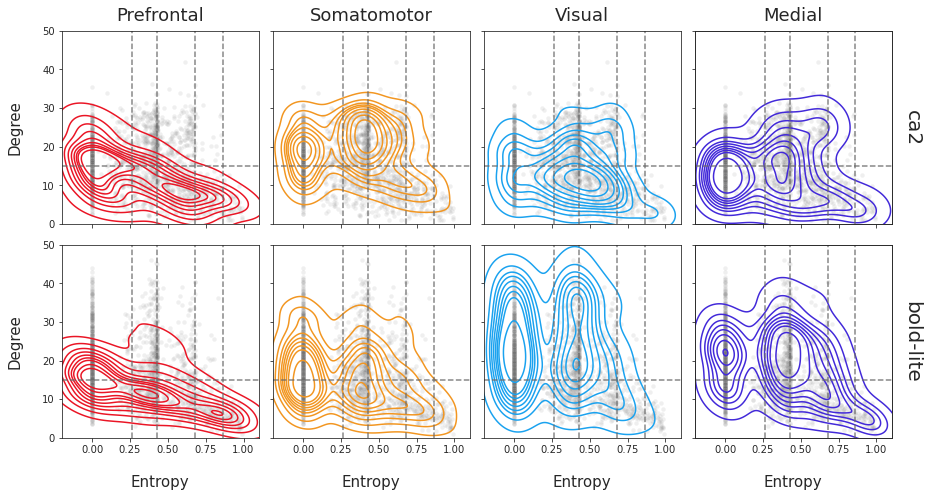

In [211]:
fig, axes = create_figure(2, len(selected), (13, 7), 'all', 'all')

for ax in axes.flat:
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--', alpha=0.8)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', alpha=0.8)

for i, af in enumerate(selected):
    for ax, (mode, c) in zip(axes[:, i].flat, pal.items()):
        _df = df.loc[
            (df['mode'] == mode) &
            (df['Affiliation'] == af)
        ]
        sns.scatterplot(
            data=df.loc[df['mode'] == mode],
            x='Entropy',
            y='Degree',
            color='dimgrey',
            s=20,
            alpha=0.1,
            ax=ax,
        )
        sns.kdeplot(
            data=_df,
            x='Entropy',
            y='Degree',
            color=affil['colors'][af],
            ax=ax,
        )
        if mode == 'ca2':
            ax.set_title(af, fontsize=18, y=1.02)
        else:
            ax.set_xlabel('Entropy', fontsize=15, labelpad=20)
        if i == len(selected) - 1:
            axtw = ax.twinx()
            axtw.set_ylabel(mode, fontsize=20, labelpad=30, rotation=-90)
            axtw.set_yticks([])
        elif i == 0:
            ax.set_ylabel('Degree', fontsize=15, labelpad=20)
ax.set_ylim((0, 50))
ax.set_xlim((-0.2, 1.1))

plt.show()

In [212]:
vedges = [0] + vlines + [1]
hedges = [0] + hlines + [100]

vedges, hedges

(
    [
        0,
        0.26264392340968856,
        0.43067655807339306,
        0.6826061944859854,
        0.8613531161467861,
        1
    ],
    [0, 15, 100]
)

In [213]:
coordinates = {}
for i in range(len(hedges) - 1):
    for j in range(len(vedges) - 1):
        coordinates[f"{i}{j}"] = (
            (hedges[i], hedges[i + 1]),
            (vedges[j], vedges[j + 1]),
        )
coordinates

{
    '00': ((0, 15), (0, 0.26264392340968856)),
    '01': ((0, 15), (0.26264392340968856, 0.43067655807339306)),
    '02': ((0, 15), (0.43067655807339306, 0.6826061944859854)),
    '03': ((0, 15), (0.6826061944859854, 0.8613531161467861)),
    '04': ((0, 15), (0.8613531161467861, 1)),
    '10': ((15, 100), (0, 0.26264392340968856)),
    '11': ((15, 100), (0.26264392340968856, 0.43067655807339306)),
    '12': ((15, 100), (0.43067655807339306, 0.6826061944859854)),
    '13': ((15, 100), (0.6826061944859854, 0.8613531161467861)),
    '14': ((15, 100), (0.8613531161467861, 1))
}

In [214]:
carto_map = {}
for k, bounds in coordinates.items():
    (lower_deg, upper_deg), (lower_h, upper_h) = bounds
    cond_h = np.logical_and(lower_h <= gr_ca.anim_h, gr_ca.anim_h < upper_h)
    cond_deg = np.logical_and(lower_deg <= gr_ca.anim_deg, gr_ca.anim_deg < upper_deg)
    cond = np.logical_and(cond_h, cond_deg)
    carto_map[k] = bn.nanmean(cond, 0)
    
carto_vec = [np.expand_dims(e, axis=0) for e in carto_map.values()]
carto_vec = np.concatenate(carto_vec)
proj = gr_ca.project_vec(carto_vec, add_disjoint=False)
tr = gr_ca.trim2d(proj)

IndexError: index 6 is out of bounds for axis 0 with size 6

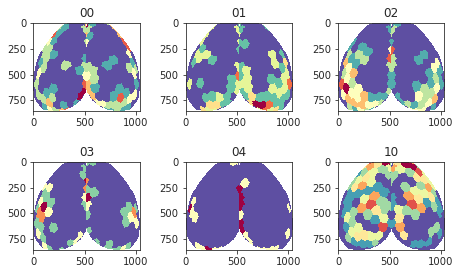

In [215]:
fig, axes = create_figure(2, 3, (6.5, 4))
for i, k in enumerate(coordinates):
    ax = axes.flat[i]
    x2p = mwh(tr['top'] == 0, tr['proj-top'][i])
    ax.imshow(x2p, cmap='Spectral_r')
    ax.set_title(k)
remove_ticks(axes)

In [ ]:
fig, axes = create_figure(2, 3, (10, 4))
for i, k in enumerate(coordinates):
    ax = axes.flat[i]
    x2p = mwh(tr['flat'] == 0, tr['proj-flat'][i])
    ax.imshow(x2p, cmap='Spectral_r')
    ax.set_title(k)
remove_ticks(axes)

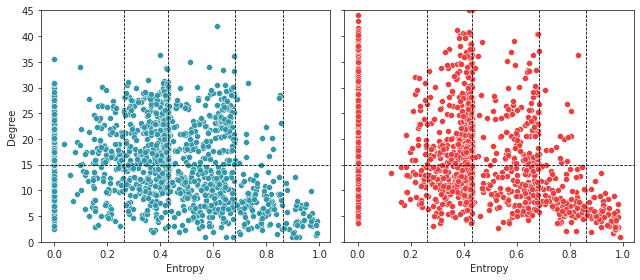

In [216]:
fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()):
    for x in vlines:
        ax.axvline(x, color='k', ls='--', lw=0.8)
    for y in hlines:
        ax.axhline(y, color='k', ls='--', lw=0.8)
    sns.scatterplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        color=c,
        ax=ax,
    )
ax.set_ylim((0, 45))

plt.show()

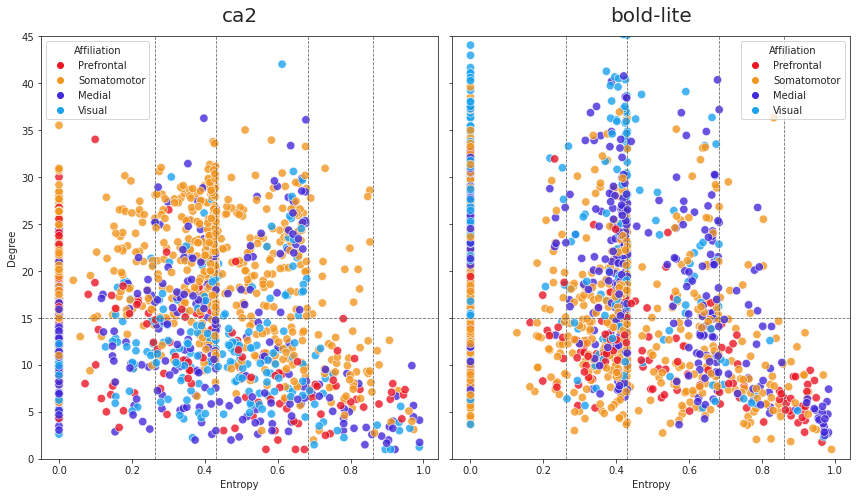

In [253]:
fig, axes = create_figure(1, 2, (12, 7), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()):
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--', lw=0.8)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', lw=0.8)
        
    _df = df.loc[
        (df['mode'] == mode) &
        (~df['Affiliation'].isin(['Auditory', 'Lateral']))
    ]
    sns.scatterplot(
        data=_df,
        x='Entropy',
        y='Degree',
        hue='Affiliation',
        palette=affil['colors'],
        s=70,
        alpha=0.8,
        ax=ax,
    )
    ax.set_title(mode, fontsize=20, y=1.02)
ax.set_ylim((0, 45))

plt.show()

In [17]:
vlines = [(0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)]
vlines += [np.log(i) / np.log(5) for i in range(2, 5)]
hlines = [np.nanquantile(np.concatenate([gr_bold.run_deg, gr_ca.run_deg]), _q) for _q in [0.50, 0.75]]

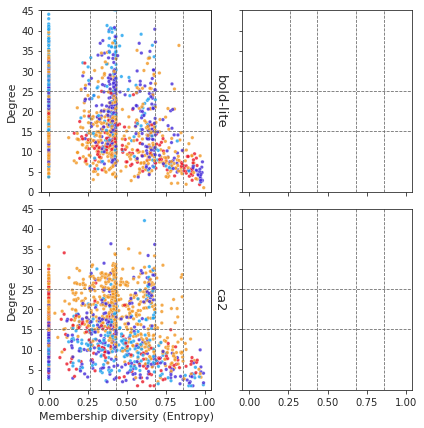

In [18]:
fig, axes = create_figure(2, 2, (6, 6), 'all', 'all')
for ax in axes.flat:
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--', lw=0.8)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', lw=0.8)

for ax, (mode, c) in zip(axes[:, 0].flat, sorted(pal.items())):        
    _df = df.loc[
        (df['mode'] == mode) &
        (~df['Affiliation'].isin(['Auditory', 'Lateral']))
    ]
    sns.scatterplot(
        data=_df,
        x='Entropy',
        y='Degree',
        hue='Affiliation',
        palette=affil['colors'],
        s=12,
        alpha=0.8,
        ax=ax,
        legend=False,
    )
    ax.set_ylabel('Degree', fontsize=11)
    if mode == 'ca2':
        ax.set_xlabel('Membership diversity (Entropy)', fontsize=11)
    axtw = ax.twinx()
    axtw.set_ylabel(mode, rotation=-90, fontsize=13, labelpad=15, loc='center')
    axtw.set_yticks([])
ax.set_ylim((0, 45))
name = f'carto-run'
figname = f"{name}.pdf"
# fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    # fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
plt.show()

In [ ]:
'sequential', 'diverging', 'qualitative'

In [290]:
sns.choose_colorbrewer_palette('sequential')

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

[
    (0.9575547866205305, 0.9575547866205305, 0.9575547866205305),
    (0.9012072279892349, 0.9012072279892349, 0.9012072279892349),
    (0.8328950403690888, 0.8328950403690888, 0.8328950403690888),
    (0.7502191464821223, 0.7502191464821223, 0.7502191464821223),
    (0.6434140715109573, 0.6434140715109573, 0.6434140715109573),
    (0.5387158785082661, 0.5387158785082661, 0.5387158785082661),
    (0.440322952710496, 0.440322952710496, 0.440322952710496),
    (0.342883506343714, 0.342883506343714, 0.342883506343714),
    (0.22329873125720878, 0.22329873125720878, 0.22329873125720878),
    (0.10469819300269129, 0.10469819300269129, 0.10469819300269129)
]

In [295]:
sns.choose_cubehelix_palette()

interactive(children=(IntSlider(value=9, description='n_colors', max=16, min=2), FloatSlider(value=0.0, descri…

[
    [0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
    [0.8888663743660877, 0.7106793139856472, 0.7158661451411206],
    [0.8314793143949643, 0.5987041921652179, 0.6530062709235388],
    [0.7588951019517731, 0.49817117746394224, 0.6058723814510268],
    [0.6672565752652589, 0.40671838146419587, 0.5620016466433286],
    [0.5529215689527474, 0.3217924564263954, 0.5093718054521851],
    [0.43082755198027817, 0.24984535814964698, 0.44393960899639856],
    [0.29794615023641036, 0.18145907625614888, 0.35317781405034754],
    [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]
]

In [19]:
cm_3 = sns.cubehelix_palette(
    n_colors=5,
    start=0,
    rot=0.1,
    gamma=1.0,
    hue=0.80,
    light=0.8,
    dark=0.4,
)
cm_3

In [20]:
cm_2 = sns.cubehelix_palette(
    n_colors=5,
    start=2.00,
    rot=0.1,
    gamma=1.0,
    hue=0.80,
    light=0.8,
    dark=0.4,
)
cm_2

In [21]:
cm_1 = sns.cubehelix_palette(
    n_colors=5,
    start=0.80,
    rot=0.1,
    gamma=1.0,
    hue=0.80,
    light=0.8,
    dark=0.4,
)
cm_1

In [22]:
cms = [cm_1, cm_3, cm_2]

In [23]:
ymax = 45
box_y = [0] + hlines + [45]
box_x = [0] + vlines + [1]

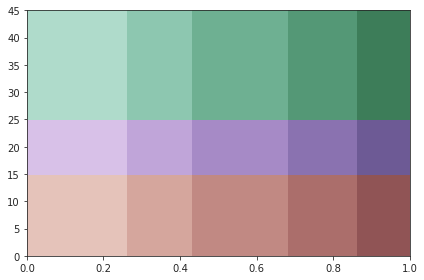

In [24]:
fig, ax = create_figure()
for i, xx in enumerate(box_x[:-1]):
    for j, yy in enumerate(box_y[:-1]):
        rect = matplotlib.patches.Rectangle(
            xy=(xx, yy),
            width=box_x[i + 1] - xx,
            height=box_y[j + 1] - yy,
            color=list(cms[j])[i],
        )
        ax.add_patch(rect)
ax.set_ylim(0, ymax)
plt.show()

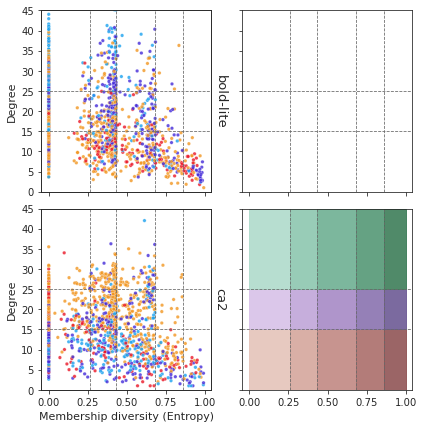

In [25]:
fig, axes = create_figure(2, 2, (6, 6), 'all', 'all')
for ax in axes.flat:
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--', lw=0.8)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', lw=0.8)

for ax, (mode, c) in zip(axes[:, 0].flat, sorted(pal.items())):        
    _df = df.loc[
        (df['mode'] == mode) &
        (~df['Affiliation'].isin(['Auditory', 'Lateral']))
    ]
    sns.scatterplot(
        data=_df,
        x='Entropy',
        y='Degree',
        hue='Affiliation',
        palette=affil['colors'],
        s=12,
        alpha=0.8,
        ax=ax,
        legend=False,
    )
    ax.set_ylabel('Degree', fontsize=11)
    if mode == 'ca2':
        ax.set_xlabel('Membership diversity (Entropy)', fontsize=11)
    axtw = ax.twinx()
    axtw.set_ylabel(mode, rotation=-90, fontsize=13, labelpad=15, loc='center')
    axtw.set_yticks([])
    
ax = axes[1, 1]
for i, xx in enumerate(box_x[:-1]):
    for j, yy in enumerate(box_y[:-1]):
        rect = matplotlib.patches.Rectangle(
            xy=(xx, yy),
            width=box_x[i + 1] - xx,
            height=box_y[j + 1] - yy,
            color=list(cms[j])[i],
            alpha=0.9,
        )
        ax.add_patch(rect)
ax.set_ylim((0, 45))

name = f'carto-run'
figname = f"{name}.pdf"
# fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    # fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
plt.show()

In [63]:
f = 'parcel2d-flat_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parcel_flat = ants.image_read(f, pixeltype='unsigned int')
parcel_flat = parcel_flat.numpy()

f = 'parcel2d-top_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parcel_top = ants.image_read(f, pixeltype='unsigned int')
parcel_top = parcel_top.numpy()

<matplotlib.image.AxesImage object at 0x7f4fdabb6ee0>

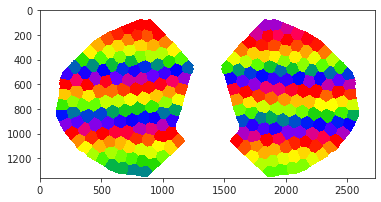

In [64]:
x2p = mwh(parcel_flat == 0, parcel_flat)
plt.imshow(x2p, cmap='prism')

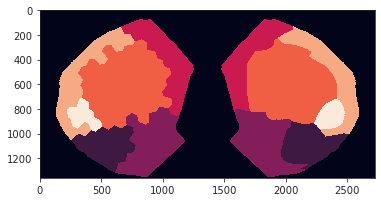

In [66]:
affil_max_flat = np.zeros_like(parcel_flat)
for r, af in affil['regions_affil_max'].items():
    affil_max_flat[parcel_flat == r] = list(affil['affiliation']).index(af) + 1

m = np.isin(parcel_flat, affil['regions_r'])
affil_max_flat[m] = affil['obj_flat'][m]
affil_max_flat[parcel_flat == 0] = 0
plt.imshow(affil_max_flat);

In [76]:
regions_included = [
    mice.parcel.encode(1, int(lbl.split('-')[1]), 0)
    for lbl in gr_ca.l2n
]
regions_included = np.array(regions_included)
regions_included = regions_included[gr_ca.l_ids]

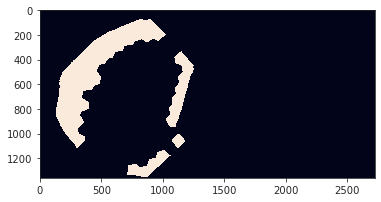

In [77]:
mask_f = np.zeros(parcel_flat.shape)
mask_f[np.isin(parcel_flat, affil['regions_l'])] = 1
mask_f[np.isin(parcel_flat, regions_included)] = 0
plt.imshow(mask_f);

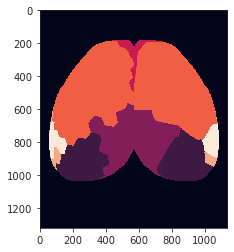

In [78]:
affil_max_top = np.zeros_like(parcel_top)
for r, af in affil['regions_affil_max'].items():
    affil_max_top[parcel_top == r] = list(affil['affiliation']).index(af) + 1

m = np.isin(parcel_top, affil['regions_r'])
affil_max_top[m] = affil['obj_top'][m]
affil_max_top[parcel_top == 0] = 0
plt.imshow(affil_max_top);

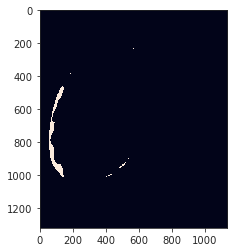

In [79]:
mask_t = np.zeros(parcel_top.shape)
mask_t[np.isin(parcel_top, affil['regions_l'])] = 1
mask_t[np.isin(parcel_top, regions_included)] = 0
plt.imshow(mask_t);

In [80]:
mf_tr, f_tr = filter_boundaries([mask_f, affil_max_flat], mask=affil_max_flat)
mt_tr, t_tr = filter_boundaries([mask_t, affil_max_top], mask=affil_max_top)

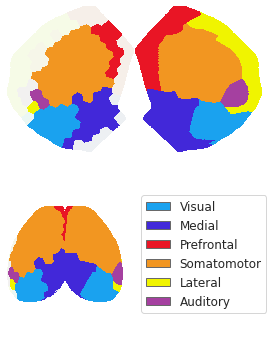

In [83]:
fig = plt.figure(figsize=(4, 5), tight_layout=True)
gs = GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
x2p = mwh(f_tr == 0, f_tr)
ax.imshow(x2p, cmap=affil['cmap'])
x2p = mwh(mf_tr == 0, mf_tr)
ax.imshow(x2p, cmap='Greens', interpolation='none', alpha=0.95)
remove_ticks(ax)

ax = fig.add_subplot(gs[1, 0])
x2p = filter_boundaries(t_tr, t_tr)
x2p = mwh(x2p == 0, x2p)
ax.imshow(x2p, cmap=affil['cmap'])
x2p = mwh(mt_tr == 0, mt_tr)
ax.imshow(x2p, cmap='Greens', interpolation='none', alpha=0.95)
remove_ticks(ax)

ax = fig.add_subplot(gs[1, 1])
legend_elements = [
    matplotlib.patches.Patch(facecolor=c, edgecolor='dimgrey', label=lbl)
    for lbl, c in affil['colors'].items()
]
leg = ax.legend(handles=legend_elements, fontsize=12, loc='center')
remove_ticks(ax)

#### Boundary plots

In [232]:
from scipy import ndimage

<matplotlib.image.AxesImage object at 0x7f4fb9af3970>

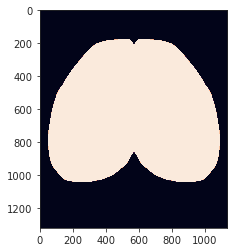

In [233]:
x = (parcel_top > 0).astype(float)
x = ndimage.gaussian_filter(x, sigma=1)
x = (x > 0).astype(float)
x = ndimage.gaussian_filter(x, sigma=0.5)
plt.imshow(x)

In [234]:
contour = ~np.logical_or(
    ndimage.sobel(x, axis=0),
    ndimage.sobel(x, axis=1),
)

<matplotlib.image.AxesImage object at 0x7f4fb9820580>

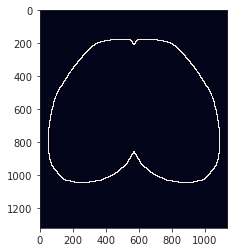

In [235]:
plt.imshow(contour == 0)

<matplotlib.image.AxesImage object at 0x7f4fb78da100>

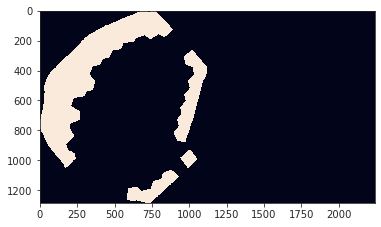

In [316]:
plt.imshow(mf_tr)

<matplotlib.image.AxesImage object at 0x7f4fb7c29760>

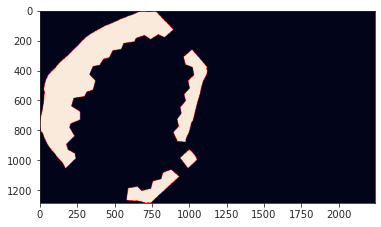

In [317]:
x = mf_tr.astype(float)
x = ndimage.gaussian_filter(x, sigma=2.5)
#x = (x > 0).astype(float)
#x = ndimage.gaussian_filter(x, sigma=1)
plt.imshow(x)

In [318]:
contour_f = np.logical_or(
    ndimage.sobel(x, axis=0),
    ndimage.sobel(x, axis=1),
)

<matplotlib.image.AxesImage object at 0x7f4fb80b55b0>

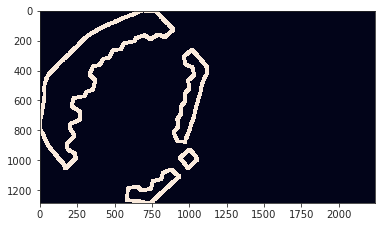

In [319]:
plt.imshow(contour_f)

<matplotlib.image.AxesImage object at 0x7f4fb6759850>

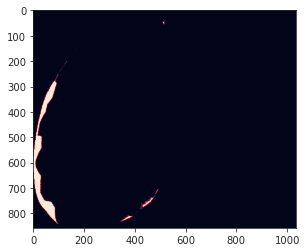

In [331]:
x = mt_tr.astype(float)
x = ndimage.gaussian_filter(x, sigma=1.5)
plt.imshow(x)

In [332]:
contour_t = np.logical_or(
    ndimage.sobel(x, axis=0),
    ndimage.sobel(x, axis=1),
)

<matplotlib.image.AxesImage object at 0x7f4fb66bb1f0>

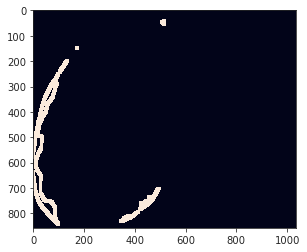

In [333]:
plt.imshow(contour_t)

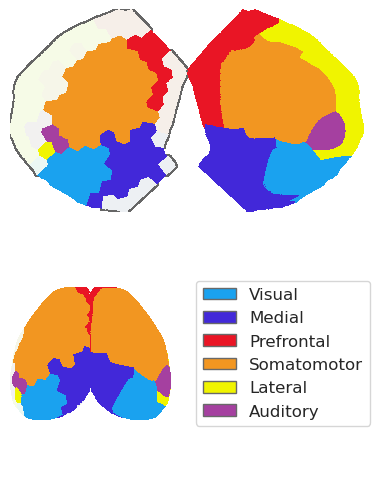

In [334]:
fig = plt.figure(figsize=(4, 5), tight_layout=True, dpi=100)
gs = GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax.imshow(contour_f, cmap='Greys', interpolation='none', alpha=0.6)
x2p = mwh(f_tr == 0, f_tr)
ax.imshow(x2p, cmap=affil['cmap'])
x2p = mwh(mf_tr == 0, mf_tr)
ax.imshow(x2p, cmap='Greens', interpolation='none', alpha=0.95)
# x2p = mwh(contour == 1, contour)

remove_ticks(ax)

ax = fig.add_subplot(gs[1, 0])
x2p = filter_boundaries(t_tr, t_tr)
x2p = mwh(x2p == 0, x2p)
ax.imshow(x2p, cmap=affil['cmap'])
x2p = mwh(mt_tr == 0, mt_tr)
ax.imshow(x2p, cmap='Greens', interpolation='none', alpha=0.95)
remove_ticks(ax)

ax = fig.add_subplot(gs[1, 1])
legend_elements = [
    matplotlib.patches.Patch(facecolor=c, edgecolor='dimgrey', label=lbl)
    for lbl, c in affil['colors'].items()
]
leg = ax.legend(handles=legend_elements, fontsize=12, loc='center')
remove_ticks(ax)

In [383]:
save_dir = pjoin(fig_dir, 'carto')
os.makedirs(save_dir, exist_ok=True)

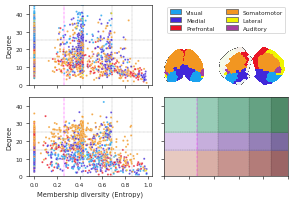

In [390]:
fig = plt.figure(figsize=(5, 3.5), tight_layout=True, dpi=60)
gs = GridSpec(4, 4, height_ratios=[0.8, 1] * 2, width_ratios=[1, 1.8] * 2)

for i, (mode, c) in enumerate(sorted(pal.items())):
    ax = fig.add_subplot(gs[2*i:2*(i+1), :2])
    for vi, x in enumerate(vlines):
        c = 'magenta' if vi == 0 else 'dimgrey'
        ls = '-.' if vi == 0 else '--'
        lw = 0.5 if vi == 0 else 0.3
        ax.axvline(x, color=c, ls=ls, lw=lw, zorder=0)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', lw=0.3, alpha=1, zorder=0)
    
    _df = df.loc[
        (df['mode'] == mode) # &
        # (~df['Affiliation'].isin(['Auditory', 'Lateral']))
    ]
    sns.scatterplot(
        data=_df,
        x='Entropy',
        y='Degree',
        hue='Affiliation',
        palette=affil['colors'],
        s=6,
        alpha=0.8,
        legend=False,
        ax=ax,
    )
    ax.set_ylabel('Degree', fontsize=8)
    ax.tick_params(axis='both', labelsize=7)
    ax.set_ylim((0, 45))
    if mode == 'ca2':
        ax.set_xlabel('Membership diversity (Entropy)', fontsize=8)
        xticks = ax.get_xticks()
        xlim = ax.get_xlim()
    else:
        ax.tick_params(axis='x', labelbottom=False)
        ax.set_xlabel('')
    yticks = ax.get_yticks()

ax = fig.add_subplot(gs[1, 3])
ax.imshow(contour_f, cmap='Greys', interpolation='none', alpha=0.6)
x2p = mwh(f_tr == 0, f_tr)
ax.imshow(x2p, cmap=affil['cmap'])
x2p = mwh(mf_tr == 0, mf_tr)
ax.imshow(x2p, cmap='Greens', interpolation='none', alpha=0.95)
# x2p = mwh(contour == 1, contour)

remove_ticks(ax)

ax = fig.add_subplot(gs[1, 2])
ax.imshow(contour_t, cmap='Greys', interpolation='none', alpha=0.6)
# x2p = filter_boundaries(t_tr)
x2p = mwh(t_tr == 0, t_tr)
ax.imshow(x2p, cmap=affil['cmap'])
x2p = mwh(mt_tr == 0, mt_tr)
ax.imshow(x2p, cmap='Greens', interpolation='none', alpha=0.95)
remove_ticks(ax)

ax = fig.add_subplot(gs[0, 2:])
legend_elements = [
    matplotlib.patches.Patch(facecolor=c, edgecolor='dimgrey', label=lbl)
    for lbl, c in affil['colors'].items()
]
leg = ax.legend(handles=legend_elements, fontsize=7, ncol=2, loc='center')
remove_ticks(ax)
    # axtw = ax.twinx()
    # axtw.set_ylabel(mode, rotation=-90, fontsize=13, labelpad=15, loc='center')
    # axtw.set_yticks([])

ax = fig.add_subplot(gs[2:, 2:])
for vi, x in enumerate(vlines):
    c = 'magenta' if vi == 0 else 'dimgrey'
    ls = '-.' if vi == 0 else '--'
    lw = 0.5 if vi == 0 else 0.4
    ax.axvline(x, color=c, ls=ls, lw=lw)
for y in hlines:
    ax.axhline(y, color='dimgrey', ls='--', lw=0.4)
for i, xx in enumerate(box_x[:-1]):
    for j, yy in enumerate(box_y[:-1]):
        rect = matplotlib.patches.Rectangle(
            xy=(xx, yy),
            width=box_x[i + 1] - xx,
            height=box_y[j + 1] - yy,
            color=list(cms[j])[i],
            alpha=0.9,
        )
        ax.add_patch(rect)
# ax.set_xlabel('Membership diversity (Entropy)', fontsize=8)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
# ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='x', labelbottom=False)
ax.tick_params(axis='y', labelleft=False)
ax.set_xlim((0, 1))
ax.set_ylim((0, 45))

name = f'carto-run'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
plt.show()

In [ ]:
fig, axes = create_figure(2, 2, (6, 6), 'all', 'all')
for ax in axes.flat:
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--', lw=0.8)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', lw=0.8)

for ax, (mode, c) in zip(axes[:, 0].flat, sorted(pal.items())):        
    _df = df.loc[
        (df['mode'] == mode) &
        (~df['Affiliation'].isin(['Auditory', 'Lateral']))
    ]
    sns.scatterplot(
        data=_df,
        x='Entropy',
        y='Degree',
        hue='Affiliation',
        palette=affil['colors'],
        s=12,
        alpha=0.8,
        ax=ax,
        legend=False,
    )
    ax.set_ylabel('Degree', fontsize=11)
    if mode == 'ca2':
        ax.set_xlabel('Membership diversity (Entropy)', fontsize=11)
    axtw = ax.twinx()
    axtw.set_ylabel(mode, rotation=-90, fontsize=13, labelpad=15, loc='center')
    axtw.set_yticks([])
    
ax = axes[1, 1]
for i, xx in enumerate(box_x[:-1]):
    for j, yy in enumerate(box_y[:-1]):
        rect = matplotlib.patches.Rectangle(
            xy=(xx, yy),
            width=box_x[i + 1] - xx,
            height=box_y[j + 1] - yy,
            color=list(cms[j])[i],
            alpha=0.9,
        )
        ax.add_patch(rect)
ax.set_ylim((0, 45))

name = f'carto-run'
figname = f"{name}.pdf"
# fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    # fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
plt.show()

### Group

In [258]:
num = len(gr_ca.grp_h.flat)
gr_ca.grp_deg = bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_deg, 2), 1), 0)
gr_bold.grp_deg = bn.nanmean(bn.nanmean(bn.nanmean(gr_bold.run_deg, 2), 1), 0)

In [259]:
df = pd.DataFrame({
    'mode': ['ca2'] * num + ['bold-lite'] * num,
    'Degree': list(gr_ca.grp_deg.flat) + list(gr_bold.grp_deg.flat),
    'Entropy': list(gr_ca.grp_h.flat) + list(gr_bold.grp_h.flat),
    'Affiliation': affil_included * 2,
})

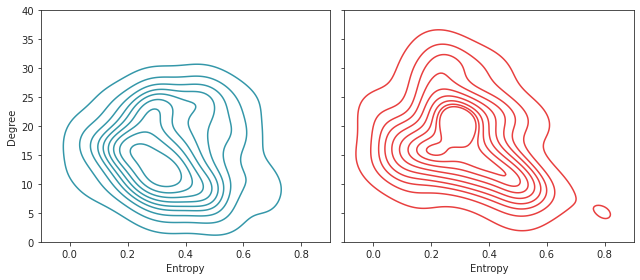

In [260]:
fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()): 
    sns.kdeplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        # cmap='mako' if mode == 'ca2' else 'rocket',
        color=c,
        ax=ax,
    )
ax.set_ylim((0, 40))
ax.set_xlim((-0.1, 0.9))
plt.show()

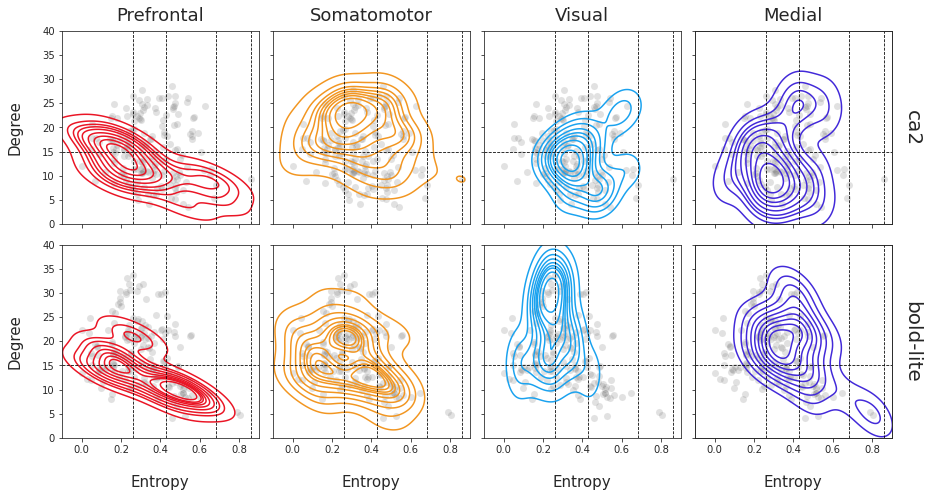

In [261]:
fig, axes = create_figure(2, len(selected), (13, 7), 'all', 'all')

for ax in axes.flat:
    for x in vlines:
        ax.axvline(x, color='k', ls='--', lw=0.8)
    for y in hlines:
        ax.axhline(y, color='k', ls='--', lw=0.8)

for i, af in enumerate(selected):
    for ax, (mode, c) in zip(axes[:, i].flat, pal.items()):
        _df = df.loc[
            (df['mode'] == mode) &
            (df['Affiliation'] == af)
        ]
        sns.scatterplot(
            data=df.loc[df['mode'] == mode],
            x='Entropy',
            y='Degree',
            color='dimgrey',
            s=50,
            alpha=0.2,
            ax=ax,
        )
        sns.kdeplot(
            data=_df,
            x='Entropy',
            y='Degree',
            color=affil['colors'][af],
            ax=ax,
        )
        if mode == 'ca2':
            ax.set_title(af, fontsize=18, y=1.02)
        else:
            ax.set_xlabel('Entropy', fontsize=15, labelpad=20)
        if i == len(selected) - 1:
            axtw = ax.twinx()
            axtw.set_ylabel(mode, fontsize=20, labelpad=30, rotation=-90)
            axtw.set_yticks([])
        elif i == 0:
            ax.set_ylabel('Degree', fontsize=15, labelpad=20)
            # axtw.yaxis.set_label_position("right")
ax.set_ylim((0, 40))
ax.set_xlim((-0.1, 0.9))

plt.show()

In [262]:
vedges = [0] + vlines + [1]
hedges = [0] + hlines + [100]

coordinates = {}
for i in range(len(hedges) - 1):
    for j in range(len(vedges) - 1):
        coordinates[f"{i}{j}"] = (
            (hedges[i], hedges[i + 1]),
            (vedges[j], vedges[j + 1]),
        )
coordinates

{
    '00': ((0, 15), (0, 0.26264392340968856)),
    '01': ((0, 15), (0.26264392340968856, 0.43067655807339306)),
    '02': ((0, 15), (0.43067655807339306, 0.6826061944859854)),
    '03': ((0, 15), (0.6826061944859854, 0.8613531161467861)),
    '04': ((0, 15), (0.8613531161467861, 1)),
    '10': ((15, 100), (0, 0.26264392340968856)),
    '11': ((15, 100), (0.26264392340968856, 0.43067655807339306)),
    '12': ((15, 100), (0.43067655807339306, 0.6826061944859854)),
    '13': ((15, 100), (0.6826061944859854, 0.8613531161467861)),
    '14': ((15, 100), (0.8613531161467861, 1))
}

In [263]:
carto_map = {}
for k, bounds in coordinates.items():
    (lower_deg, upper_deg), (lower_h, upper_h) = bounds
    cond_h = np.logical_and(lower_h <= gr_ca.grp_h, gr_ca.grp_h < upper_h)
    cond_deg = np.logical_and(lower_deg <= gr_ca.grp_deg, gr_ca.grp_deg < upper_deg)
    cond = np.logical_and(cond_h, cond_deg)
    carto_map[k] = cond.astype(float)
    
carto_vec = [np.expand_dims(e, axis=0) for e in carto_map.values()]
carto_vec = np.concatenate(carto_vec)
proj = gr_ca.project_vec(carto_vec, add_disjoint=False)
tr = gr_ca.trim2d(proj)